In [207]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from scipy.ndimage import gaussian_filter
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind
from icl_draw import drawsnap, add_scalebar, addtext
import argparse, subprocess

# Data Preparation

In [208]:
mode1 = 'nh'
fout1 = 1026
repo1,rurmode1,dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, fout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']
gal1s = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
hal1s, hmpid1s = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1, load_parts=True)
halo_id1s = np.repeat(hal1s['id'], hal1s['nparts'])

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)


In [209]:
mode2 = 'nh2'
fout2 = 797
repo2,rurmode2,dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, fout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2)
snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']
gal2s = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
hal2s, hmpid2s = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2, load_parts=True)
halo_id2s = np.repeat(hal2s['id'], hal2s['nparts'])

[Output 00797] Age (Gyr) : 11.623 / 13.741, z = 0.17158 (a = 0.8536)


In [210]:
matchid = pklload(f"{repo1}/DMID_NH_to_NH2.pickle")
matchid.shape

(2, 126492136)

In [211]:
result1s = pklload("./database/01_nh_ghmatch.pickle")
result2s = pklload("./database/01_nh2_ghmatch.pickle")
print(result1s.shape, gal1s.shape)
print(result2s.shape, gal2s.shape)

(4070,) (4070,)
(1528,) (1528,)


In [212]:
# target1s = gal1s[ (gal1s['m'] >= 10**9.5) & (result1s['halo_id'] > 0) & (result1s['central'])]
# print(len(target1s))
target1s = gal1s[ (gal1s['nparts'] >= 10**6) & (result1s['halo_id'] > 0) & (result1s['central'])]
print(len(target1s))

62


In [213]:
dt1 = target1s.dtype.descr
dt2 = result1s.dtype.descr
dt2 = [idt2 for idt2 in dt2 if(idt2 not in dt1)]
dt3 = [
       ('r200', 'f8'), ('m200', 'f8'), ('r200_code', 'f8'), 
       ('m_star_200', 'f8'), ('m_gas_200', 'f8'), ('fcontam_200', 'f8'),
       ('rp','f8'), ('sfr', 'f8'), ('sfr_tot', 'f8'), 
       ('galaxy_nh2', 'i8'), ('halo_nh2', 'i8'), ('matchrate', 'f8')]
set(dt1)|set(dt2)
dtype = np.dtype(dt1 + dt2 + dt3)
MWA1s = np.zeros(len(target1s), dtype=dtype)
for iname in dtype.names:
    if(iname in target1s.dtype.names):
        MWA1s[iname] = target1s[iname]
    elif(iname in result1s.dtype.names):
        MWA1s[iname] = result1s[target1s['id']-1][iname]
    else:
        pass
print(MWA1s.dtype.names)
print(MWA1s[0])

('nparts', 'id', 'timestep', 'level', 'host', 'hostsub', 'nbsub', 'nextsub', 'aexp', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Lx', 'Ly', 'Lz', 'r', 'a', 'b', 'c', 'ek', 'ep', 'et', 'spin', 'sigma', 'sigma_bulge', 'm_bulge', 'rvir', 'mvir', 'tvir', 'cvel', 'rho0', 'rc', 'halo_id', 'halo_nparts', 'halo_level', 'halo_host', 'halo_hostsub', 'halo_x', 'halo_y', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_mvir', 'halo_rvir', 'fcontam', 'dist', 'central', 'main', 'r200', 'm200', 'r200_code', 'm_star_200', 'm_gas_200', 'fcontam_200', 'rp', 'sfr', 'sfr_tot', 'galaxy_nh2', 'halo_nh2', 'matchrate')
(6459716, 1, 1026, 1, 1, 0, 58, 1115, 0.85361391, 5.70733728e+10, 0.46676515, 0.47558907, 0.51981606, 38.10322621, 59.92555592, 42.18115311, 4.36736485e+09, 1.96773168e+10, -3.41279546e+10, 0.00059946, 0.00971647, 0.00790458, 0.00462674, 18406.16921386, -5712.74814868, 12693.42106518, 0.42191258, 193.48360624, 192.9882045, 0.23801002, 0.000533, 5.70733728e+10, 136357.35271673, 61.62998287, 168.25461

3 3 [1252]
7 7 [1545 1551]
11 11 [21]
13 13 [14]
14 14 [  13  133  148 1920]
21 21 [11]
133 133 [14]
148 148 [14]
1252 3 [3]
1545 7 [7]
1551 7 [7]
1920 14 [14]


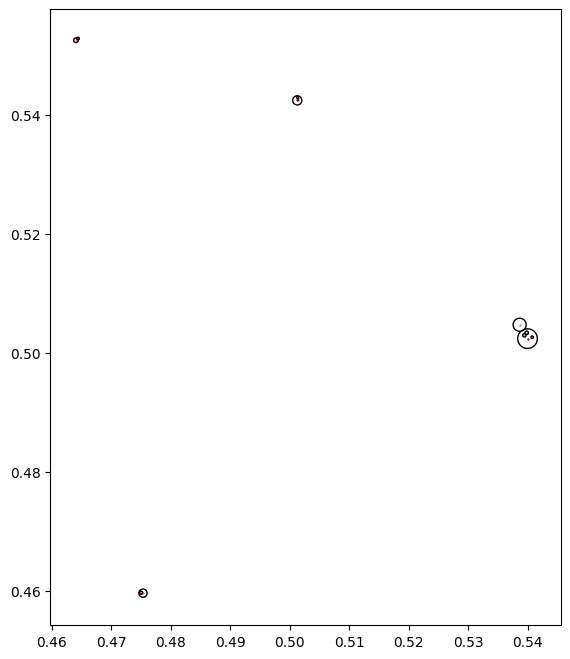

In [214]:
fig, ax = plt.subplots(figsize=(8, 8))
# ax.scatter(MWA1s['x'], MWA1s['y'], s=0.1, c='k')
for MWA1 in MWA1s:
    temp = MWA1s[MWA1s['id'] != MWA1['id']]
    dists = distance(temp, MWA1)
    ind = dists < (temp['r']+MWA1['r'])
    if( np.any(ind) ):
        print(MWA1['id'], MWA1['host'], temp['id'][ind])
        ax.add_patch(plt.Circle((MWA1['x'], MWA1['y']), MWA1['r'], color='k', fill=False))
        ax.scatter(temp['x'][ind], temp['y'][ind], s=0.1, c='r')
ax.set_aspect('equal')
plt.show()

# Matching Halo

In [215]:
count = 0
for a,b,c in zip(MWA1s['id'], MWA1s['halo_id'], MWA1s['fcontam']):
    end = '\t' if count%5 != 4 else '\n'
    count += 1
    print(f"h{b:05d}: {c:.2f}", end=end)
print()
print(len(MWA1s))
# ind = MWA1s['fcontam']<0.01
# MWA1s = MWA1s[ind]
print(len(MWA1s))

h01278: 0.00	h01417: 0.00	h01664: 0.02	h00573: 0.00	h24178: 0.03
h01386: 0.00	h03321: 0.20	h05461: 0.22	h24674: 0.00	h27286: 0.01
h10872: 0.13	h03997: 0.00	h20158: 0.00	h22161: 0.00	h24673: 0.00
h00688: 0.13	h20406: 0.00	h05476: 0.00	h13354: 0.00	h23150: 0.34
h09398: 0.00	h05540: 0.00	h04210: 0.00	h01340: 0.00	h11047: 0.16
h27653: 0.00	h05459: 0.41	h04068: 0.00	h00589: 0.00	h25246: 0.00
h03495: 0.27	h08188: 0.00	h23465: 0.04	h27180: 0.15	h19780: 0.00
h00480: 0.52	h10868: 0.93	h06368: 0.00	h19583: 0.00	h19515: 0.00
h24389: 0.00	h08284: 0.00	h01356: 0.00	h08291: 0.00	h13695: 0.00
h27382: 0.02	h26689: 0.78	h27352: 0.02	h27706: 0.02	h01766: 0.87
h13615: 0.00	h14945: 0.88	h02350: 0.99	h13169: 0.96	h00474: 0.98
h00522: 1.00	h10163: 1.00	h22552: 1.00	h22517: 0.00	h24517: 0.00
h24519: 0.00	h27379: 0.53	
62
62


# Matching NH2

In [216]:
dt1 = target1s.dtype.descr
dt2 = result2s.dtype.descr
dt2 = [idt2 for idt2 in dt2 if(idt2 not in dt1)]
dt3 = [
       ('r200', 'f8'), ('m200', 'f8'), ('r200_code', 'f8'), 
       ('m_star_200', 'f8'), ('m_gas_200', 'f8'), ('fcontam_200', 'f8'),
       ('rp','f8'), ('sfr', 'f8'), ('sfr_tot', 'f8'), 
       ('galaxy_nh', 'i8'), ('halo_nh', 'i8'), ('matchrate', 'f8')]

dtype = np.dtype(dt1 + dt2 + dt3)
MWA2s = np.zeros(len(target1s), dtype=dtype)


print(MWA2s.dtype.names)
print(MWA2s[0])

('nparts', 'id', 'timestep', 'level', 'host', 'hostsub', 'nbsub', 'nextsub', 'aexp', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Lx', 'Ly', 'Lz', 'r', 'a', 'b', 'c', 'ek', 'ep', 'et', 'spin', 'sigma', 'sigma_bulge', 'm_bulge', 'rvir', 'mvir', 'tvir', 'cvel', 'rho0', 'rc', 'halo_id', 'halo_nparts', 'halo_level', 'halo_host', 'halo_hostsub', 'halo_x', 'halo_y', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_mvir', 'halo_rvir', 'fcontam', 'dist', 'central', 'main', 'r200', 'm200', 'r200_code', 'm_star_200', 'm_gas_200', 'fcontam_200', 'rp', 'sfr', 'sfr_tot', 'galaxy_nh', 'halo_nh', 'matchrate')
(0, 0, 0, 0, 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., False, False, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0.)


In [217]:
for ith, MWA1 in enumerate(MWA1s):
    if(MWA1['galaxy_nh2'] > 0): continue
    dm1s = uhmi.HaloMaker.read_member_part(snap1, MWA1['halo_id'], galaxy=False, simple=False)
    dm1s = cut_sphere(dm1s, MWA1['x'], MWA1['y'], MWA1['z'], MWA1['r'])
    dmids1 = dm1s['id']

    dmids2 = matchid[1][dmids1-1]

    MWA2 = None
    arg = large_isin(hmpid2s, dmids2)
    if(True in arg):
        cand_id2s, occurence = np.unique(halo_id2s[arg], return_counts=True)
        matchrate = occurence**2 / len(dmids1) / hal2s[cand_id2s-1]['nparts'] # (A&B)^2 / A / B
        argsort = np.argsort(-matchrate)
        MWA1['halo_nh2'] = cand_id2s[argsort][0]
        MWA2s[ith]['halo_id'] = cand_id2s[argsort][0]
        MWA2s[ith]['halo_nh'] = MWA1['halo_id']
        MWA2s[ith]['galaxy_nh'] = MWA1['id']
        MWA1['matchrate'] = matchrate[argsort][0]
        for hid2, score in zip(cand_id2s[argsort], matchrate[argsort]):
            # argmax = np.argmax(matchrate)
            # hid2 = cand_id2s[argmax]; score = matchrate[argmax]
            if(hid2 in result2s['halo_id']):
                cands = result2s[result2s['halo_id']==hid2]
                if(len(cands) == 1):
                    MWA2 = cands[0]
                else:
                    if(True in cands['central']):
                        MWA2 = cands[cands['central']][0]
                    else:
                        MWA2 = cands[np.argmax(cands['r'])]
                MWA1['halo_nh2'] = hid2
                MWA1['matchrate'] = score
                MWA2s[ith]['matchrate'] = score
                MWA2s[ith]['halo_id'] = hid2
                break
        if(MWA2 is not None):
            MWA1['galaxy_nh2'] = MWA2['id']
            MWA2s[ith]['id'] = MWA2['id']
            print(f"[NH] (G{MWA1['id']}, H{MWA1['halo_id']}) <- {score:.2f} -> (G{MWA2['id']}, H{hid2}) [NH2]")
        else:
            print(f"[NH] (G{MWA1['id']}, H{MWA1['halo_id']}) <- {score:.2f} -> (H{hid2}) [NH2]")
    else:
        print(f"[NH] (G{MWA1['id']}, H{MWA1['halo_id']}) <- 0.00 -> (H?) [NH2]")
        print(f"No matched due to contamination ({MWA1['fcontam']:.2f})")    

[NH] (G1, H1278) <- 0.38 -> (G2, H1257) [NH2]
[NH] (G2, H1417) <- 0.30 -> (G1, H1420) [NH2]
[NH] (G3, H1664) <- 0.42 -> (G12, H1600) [NH2]
[NH] (G4, H573) <- 0.24 -> (G13, H524) [NH2]
[NH] (G7, H24178) <- 0.30 -> (G45, H24311) [NH2]
[NH] (G8, H1386) <- 0.46 -> (G14, H1368) [NH2]
[NH] (G9, H3321) <- 0.42 -> (G11, H3255) [NH2]
[NH] (G10, H5461) <- 0.32 -> (G3, H5656) [NH2]
[NH] (G11, H24674) <- 0.00 -> (G10, H5704) [NH2]
[NH] (G13, H27286) <- 0.01 -> (G20, H10658) [NH2]
[NH] (G14, H10872) <- 0.36 -> (G20, H10658) [NH2]
[NH] (G17, H3997) <- 0.22 -> (G23, H4183) [NH2]
[NH] (G19, H20158) <- 0.32 -> (G4, H20679) [NH2]
[NH] (G20, H22161) <- 0.26 -> (G31, H22326) [NH2]
[NH] (G21, H24673) <- 0.22 -> (G35, H24841) [NH2]
[NH] (G23, H688) <- 0.41 -> (G19, H627) [NH2]
[NH] (G24, H20406) <- 0.29 -> (G68, H20848) [NH2]
[NH] (G25, H5476) <- 0.42 -> (G18, H5706) [NH2]
[NH] (G26, H13354) <- 0.37 -> (G25, H13766) [NH2]
[NH] (G29, H23150) <- 0.13 -> (G32, H3310) [NH2]
[NH] (G35, H9398) <- 0.46 -> (G123, H

In [218]:
print( MWA1s.dtype.names )

('nparts', 'id', 'timestep', 'level', 'host', 'hostsub', 'nbsub', 'nextsub', 'aexp', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Lx', 'Ly', 'Lz', 'r', 'a', 'b', 'c', 'ek', 'ep', 'et', 'spin', 'sigma', 'sigma_bulge', 'm_bulge', 'rvir', 'mvir', 'tvir', 'cvel', 'rho0', 'rc', 'halo_id', 'halo_nparts', 'halo_level', 'halo_host', 'halo_hostsub', 'halo_x', 'halo_y', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_mvir', 'halo_rvir', 'fcontam', 'dist', 'central', 'main', 'r200', 'm200', 'r200_code', 'm_star_200', 'm_gas_200', 'fcontam_200', 'rp', 'sfr', 'sfr_tot', 'galaxy_nh2', 'halo_nh2', 'matchrate')


In [219]:
names1 = MWA2s.dtype.names
names2 = result2s.dtype.names

for MWA2 in MWA2s:
    if(MWA2['id']==0): continue
    gal = result2s[MWA2['id']-1]
    for iname in names1:
        if(iname in names2):
            MWA2[iname] = gal[iname]

# Remove weird

In [220]:
# Zero matched
where = np.where(MWA2s['id']>0)[0]
print(where)
MWA1s = MWA1s[where]
MWA2s = MWA2s[where]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 57 58 59 60 61]


In [273]:
# Duplicated
unique, counts = np.unique(MWA2s['id'], return_counts=True)
unis = unique[counts>1]

where = []
for uni in unis:
    samples = MWA2s[MWA2s['id']==uni]
    argmax = np.argmax(samples['matchrate'])
    winner = samples[argmax]
    losers = samples[samples['galaxy_nh']!=winner['galaxy_nh']]
    for loser in losers:
        where.append(loser['galaxy_nh'])
where = np.array(where)
where = np.where(np.isin(MWA1s['id'], where))[0]
where = np.isin(np.arange(len(MWA1s)), where, invert=True)
MWA1s = MWA1s[where]
MWA2s = MWA2s[where]

check_unique(MWA2s['id'])

[13 14]
[0.00983485 0.36089627]
[   7 1551]
[0.30270247 0.01022506]
[ 82 136]
[5.27707978e-06 1.68820340e-02]


In [275]:
check_unique(MWA2s['id'])

17 3997
23 4183
0.2171651559963261


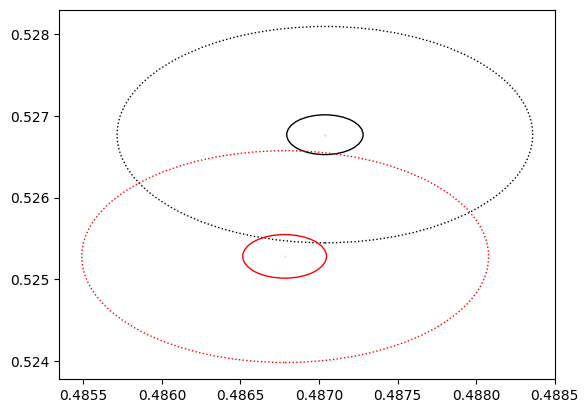

In [285]:
fig, ax = plt.subplots()

index = np.random.choice(np.arange(len(MWA1s)))
gal1 = MWA1s[index]
hal1 = hal1s[gal1['halo_id']-1]
print(gal1['id'], hal1['id'])
gal2 = MWA2s[index]
hal2 = hal2s[gal2['halo_id']-1]
print(gal2['id'], hal2['id'])
print(gal1['matchrate'])

ax.scatter(gal1['x'], gal1['y'], c='k', s=0.01)
ax.scatter(gal2['x'], gal2['y'], c='r', s=0.01)
cir = plt.Circle((gal1['x'], gal1['y']), gal1['r'], color='k', fill=False)
ax.add_patch(cir)
cir = plt.Circle((hal1['x'], hal1['y']), hal1['rvir'], color='k', fill=False, ls=':')
ax.add_patch(cir)
cir = plt.Circle((gal2['x'], gal2['y']), gal2['r'], color='r', fill=False)
ax.add_patch(cir)
cir = plt.Circle((hal2['x'], hal2['y']), hal2['rvir'], color='r', fill=False, ls=':')
ax.add_patch(cir)




In [204]:
np.where(MWA1s['galaxy_nh2']==0)

(array([52, 53, 54, 55, 56]),)

In [199]:
samples = MWA2s[MWA2s['id']==0]
samples['halo_id'], samples['matchrate']

(array([2373,    0,    0,    0,    0], dtype=int32),
 array([0., 0., 0., 0., 0.]))

In [193]:
from importlib import reload
import drawing
reload(drawing)


<module 'drawing' from '/home/jeon/MissingSat/drawing.py'>

In [201]:
samples[0]

(0, 0, 0, 0, 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2373, 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., False, False, 0., 0., 0., 0., 0., 0., 0., 0., 0., 360, 2350, 0.)

83 66


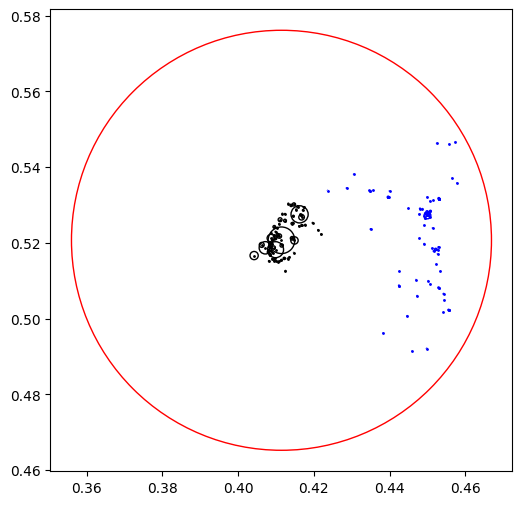

In [198]:
from drawing import nears

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nears(hal2s[2373-1], gal2s, hal2s, radii=3, ax=ax)

In [173]:
np.unique(MWA2s['id'], return_counts=True)

(array([   0,    1,    2,    3,    4,    9,   10,   11,   12,   13,   14,
          17,   18,   19,   20,   23,   25,   28,   31,   32,   33,   34,
          35,   36,   37,   38,   39,   45,   47,   52,   54,   56,   59,
          68,   73,   89,   90,   97,  101,  121,  123,  125,  131,  143,
         150,  152,  163,  187,  221,  230,  331,  600,  686,  947, 1142],
       dtype=int32),
 array([5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1]))

In [174]:
for uni, cou in zip( *np.unique(MWA2s['id'], return_counts=True) ):
    if(uni==0): continue
    if(cou>1):
        gals = MWA2s[MWA2s['id']==uni]
        print(uni, gals['halo_id'])
        print(gals['matchrate'])

20 [10658 10658]
[0.00983485 0.36089627]
45 [24311 24311]
[0.30270247 0.01022506]
947 [27219 27219]
[5.27707978e-06 1.68820340e-02]


In [175]:
29716 in result2s['halo_id']

False

In [176]:
MWA2s[MWA2s['id'] == 1]['halo_id']

array([1420], dtype=int32)

[ 143 1306 1307 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317 1318
 1319 1320 1321 1322]


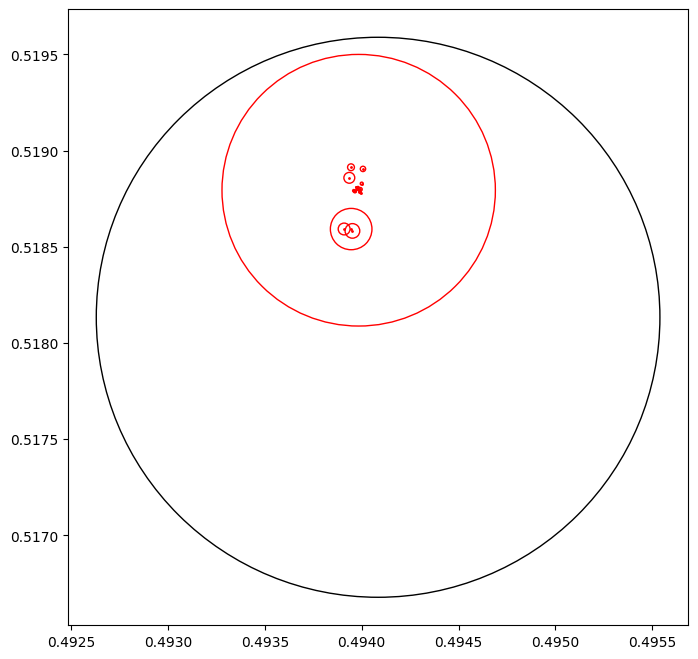

In [177]:
ihal = hal2s[8372-1]
samples = cut_sphere(gal2s, ihal['x'], ihal['y'], ihal['z'], ihal['r'], both_sphere=True)
print(samples['id'])
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(samples['x'], samples['y'], s=1, c='r')
for sample in samples:
    cir = plt.Circle((sample['x'], sample['y']), sample['r'], color='r', fill=False)
    ax.add_patch(cir)
cir = plt.Circle((ihal['x'], ihal['y']), ihal['rvir'], color='k', fill=False)
ax.add_patch(cir)

In [178]:
stop()

ValueError: stop!

In [ ]:
ihal['r']

0.003248416147653608

In [ ]:
hal2['id'], hal2['r']

(8372, 0.003248416147653608)

1 1278
2 1257
0.382021943751821


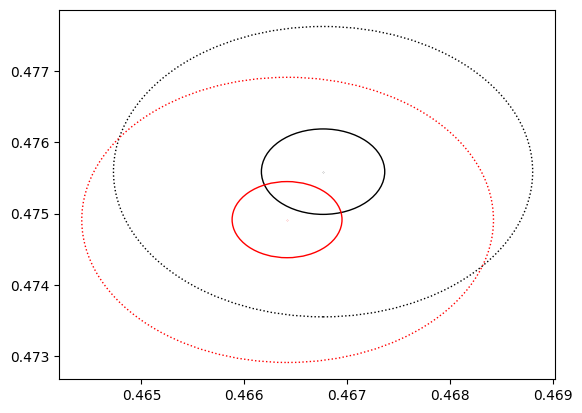

In [ ]:
fig, ax = plt.subplots()

index = np.random.choice(np.arange(len(MWA1s)))
gal1 = MWA1s[index]
hal1 = hal1s[gal1['halo_id']-1]
print(gal1['id'], hal1['id'])
gal2 = MWA2s[index]
hal2 = hal2s[gal2['halo_id']-1]
print(gal2['id'], hal2['id'])
print(gal1['matchrate'])

ax.scatter(gal1['x'], gal1['y'], c='k', s=0.01)
ax.scatter(gal2['x'], gal2['y'], c='r', s=0.01)
cir = plt.Circle((gal1['x'], gal1['y']), gal1['r'], color='k', fill=False)
ax.add_patch(cir)
cir = plt.Circle((hal1['x'], hal1['y']), hal1['rvir'], color='k', fill=False, ls=':')
ax.add_patch(cir)
cir = plt.Circle((gal2['x'], gal2['y']), gal2['r'], color='r', fill=False)
ax.add_patch(cir)
cir = plt.Circle((hal2['x'], hal2['y']), hal2['rvir'], color='r', fill=False, ls=':')
ax.add_patch(cir)




In [234]:
np.unique(MWA2s['id'], return_counts=True)

(array([   1,    2,    3,    4,    9,   10,   11,   12,   13,   14,   17,
          18,   19,   20,   23,   25,   28,   31,   32,   33,   34,   35,
          36,   37,   38,   39,   45,   47,   52,   54,   56,   59,   68,
          73,   89,   90,   97,  101,  121,  123,  125,  131,  143,  150,
         152,  163,  187,  221,  230,  331,  600,  686,  947, 1142],
       dtype=int32),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 1]))

In [233]:
check_unique(MWA1s['halo_nh2'])

AssertionError: 

In [ ]:
for a,b in zip(MWA1s['halo_nh2'], MWA1s['matchrate']):
    print(a,b)

1257 0.382021943751821
1420 0.29854657496399606
1600 0.42226189481724047
524 0.2401499357962959
6516 0.37441501206508204
24311 0.3027024723453145
1368 0.45943404272579136
3255 0.41981918351392844
5656 0.3212715822750079
5704 9.430108710794845e-05
10658 0.009834853954282017
10658 0.3608962739007988
5853 0.4900043631427963
4183 0.2171651559963261
20851 0.42402978828944654
20679 0.32387216137928515
22326 0.26466997821164756
24841 0.22461178403252924
24944 0.3646436448325231
627 0.4143493152676669
20848 0.29055503148812584
5706 0.4233054005554245
13766 0.36503465119690026
3310 0.12679089522749565
9307 0.4640033639792423
5752 0.34570212995304345
4396 0.4213679122163646
1280 0.3061650539772051
1302 0.4143570614890481
10950 0.08334489265918292
28028 0.40854180243744276
5680 0.244185726102587
13752 0.31246870789324327
1420 0.0003521068658652108
4234 0.3435790550770261
545 0.18782550270613718
477 0.2294979343726274
25351 0.3048421860787589
1420 0.00040833215016524506
3559 0.35949405661757644
83

In [ ]:
unique, counts = np.unique(MWA1s['galaxy_nh2'])

array([   2,    1,   12,   13,    5,   45,   14,   11,    3,   10,   20,
         20,    7,   23,   16,    4,   31,   35,  104,   19,   68,   18,
         25,   32,  123,   37,   73,   26,   52,   33,   47,  686,  177,
          1,   39,   28,  190,   54,    1,   17,  131,   59,   36,   64,
         34,  227,   79,  130,  150,    1,  947,   88,  101,   86,   87,
         75,   56,  125,   49,  105,  134,  121,  163,   90,  186,  132,
         82,  127,  143,   89,  152,  947,  162,  114,  181,   97,   96,
        120,  156,    9,  230,  153,  324,  141,  106,  144,  222,  103,
        189,  221,  268,  331,   85,  241,  179,  277,  251,    0,   66,
        191,  600,  600,  851,   38, 1142,   45,  187,   18,  131],
      dtype=int32)

In [ ]:
MWA1s['galaxy_nh2']

array([  2,   1,  12,  13,   5,  45,  14,  11,   3,  10,  20,  20,   7,
        23,  16,   4,  31,  35, 104,  19,  68,  18,  25,  32, 123,  37,
        73,  26,  52,  33,  47, 686, 177,   1,  39,  28, 190,  54,   1,
        17, 131,  59,  36,  64,  34, 227,  79, 130, 150,   1,  20,  88,
       101,  86,  87,  75,  56, 125,  49, 105, 134, 121, 163,  90, 186,
       132,   1,  54, 143,  89, 152,  20, 162, 114, 181,  97,  96, 120,
       156,   9, 230, 153, 324, 141, 106, 144, 222, 103, 189, 221,  10,
       331,  85, 241, 179, 277, 251,   0,  66, 191, 600, 600,   1,  38,
        45,  45, 187,  18, 131])

In [ ]:
matchrate*100

array([3.78237613e+01, 1.40765766e-02, 1.40765766e-02, 4.22297297e-02,
       1.40765766e-02, 1.40765766e-02, 1.40765766e-02, 1.40765766e-02,
       4.22297297e-02, 1.40765766e-02, 1.40765766e-02, 1.40765766e-02,
       4.22297297e-02, 1.40765766e-02, 6.00506757e+01, 2.81531532e-02,
       1.40765766e-02, 5.20833333e-01, 2.81531532e-02, 8.44594595e-02,
       2.81531532e-02, 1.40765766e-02])

In [ ]:
samples['halo_id'], samples['matchrate']

(array([ 1417, 22211, 22255, 22150, 22175, 22217], dtype=int32),
 array([0.91104946, 0.53456221, 0.62575423, 0.88772846, 0.7390328 ,
        0.82696994]))

In [ ]:
samples['halo_id'], samples['matchrate']

(array([ 1417, 22211, 22255, 22150], dtype=int32),
 array([0.29854657, 0.00035211, 0.00040833, 0.00032425]))

# Virial Properties

In [ ]:
count = 0
for MWA1, MWA2 in tqdm(zip(MWA1s, MWA2s), total=len(MWA1s)):
    count+=1
    ######################################################################
    #       NH I
    ######################################################################
    # Calculate Virial
    hal1 = hal1s[MWA1['halo']-1]
    r200_code = 1
    factor = 0.7
    while(r200_code > hal1['rvir']*factor):
        factor += 0.4
        snap1.set_box_halo(hal1, radius=factor, radius_name='rvir')
        snap1.get_part(nthread=24, target_fields=['x','y','z','m','id','epoch'])
        snap1.get_cell(nthread=24, target_fields=['x','y','z','rho','level','cpu'])

        r200, m200, r200_code = calc_virial(MWA1['x'], MWA1['y'], MWA1['z'], snap1.part['star'], snap1.part['dm'], snap1.cell)
    MWA1['r200'] = r200
    MWA1['m200'] = m200
    MWA1['r200_code'] = r200_code

    # Calculate other properties
    star = snap1.part['star']
    gal_mem_ids = uhmi.HaloMaker.read_member_part(snap1, MWA1['id'], galaxy=True, simple=True)
    isin = large_isin(np.abs(star['id']), gal_mem_ids)
    gal_mem = star[isin]
    young_ind = np.where(gal_mem['age', 'Gyr'] < 0.1)[0]
    SFR = np.sum(gal_mem['m', 'Msol'][young_ind]) / 1e8 # Msol / yr
    MWA1['sfr'] = SFR

    instar = cut_sphere(star, MWA1['x'], MWA1['y'], MWA1['z'], r200_code)
    young_ind = np.where(instar['age', 'Gyr'] < 0.1)[0]
    SFR_tot = np.sum(instar['m', 'Msol'][young_ind]) / 1e8 # Msol / yr
    MWA1['sfr_tot'] = SFR_tot
    MWA1['m_star_200'] = np.sum(instar['m', 'Msol'])

    ingas = cut_sphere(snap1.cell, MWA1['x'], MWA1['y'], MWA1['z'], r200_code)
    MWA1['m_gas_200'] = np.sum(ingas['m', 'Msol']) # Msol

    indm = cut_sphere(snap1.part['dm'], MWA1['x'], MWA1['y'], MWA1['z'], r200_code)
    minmass = np.min(snap1.part['dm']['m'])
    ind = indm['m'] > minmass*1.1
    if(True in ind):
        fcontam = np.sum(indm['m'][ind]) / np.sum(indm['m'])
    else:
        fcontam = 0
    MWA1['fcontam'] = fcontam


    # Drawing maps
    dpi = 1440
    starmap = painter.partmap(snap1.part['star'], box=snap1.box, shape=dpi, method='hist')
    cellmap = painter.gasmap(snap1.cell, box=snap1.box, shape=dpi, minlvl=13, weights=snap1.cell['rho'])
    dmmap1 = painter.partmap(snap1.part['dm'], box=snap1.box, shape=120, method='hist')
    vmax = int(np.log10(np.nanmax(dmmap1)))
    dmmap = gaussian_filter(np.log10(dmmap1), 1.5)

    # Preparation
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)
    ax.set_facecolor('k')
    ax.axis('equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)


    # Background map
    vmin = vmax - 5

    smap = plt.cm.afmhot
    gmap = drawer.make_cmap([[0,0,0], [2/255,2/255,25/255], [25/255, 25/255, 112/255], [25/255, 191/255, 255/255], [255/255, 255/255, 255/255]], position=[0, 0.25, 0.5,0.8,1])
    combine = painter.composite_image([cellmap, starmap], [gmap, smap], mode='screen', qscales=[4.5, 3.7])
    ax.imshow(combine, origin='lower', extent=[snap1.box[0,0], snap1.box[0,1], snap1.box[1,0], snap1.box[1,1]])
    ax.contour(
        dmmap, levels=np.linspace(vmin,vmax,25), colors='grey', alpha=0.7, origin='lower', 
        extent=[snap1.box[0,0], snap1.box[0,1], snap1.box[1,0], snap1.box[1,1]], linewidths=0.25
        )


    # Circles
    cir_gal = plt.Circle((MWA1['x'], MWA1['y']), MWA1['r'], color='yellow', fill=False, lw=0.3)
    ax.add_patch(cir_gal)
    ax.text(MWA1['x'], MWA1['y']+MWA1['r'], "$R_{star, max}$", ha='center', va='bottom', color='yellow', fontsize=10)
    ax.text(MWA1['x'], MWA1['y']-MWA1['r'], f"{MWA1['r']/snap1.unit['kpc']:.1f} kpc", ha='center', va='top', color='yellow', fontsize=10)

    cir_hal1 = plt.Circle((hal1['x'], hal1['y']), hal1['rvir'], color='magenta', fill=False, lw=0.3)
    ax.add_patch(cir_hal1)
    ax.text(hal1['x'], hal1['y']+hal1['rvir'], "$R_{vir, HM}$", ha='center', va='bottom', color='magenta', fontsize=10)
    ax.text(hal1['x'], hal1['y']-hal1['rvir'], f"{hal1['rvir']/snap1.unit['kpc']:.1f} kpc", ha='center', va='top', color='magenta', fontsize=10)

    cir_vir = plt.Circle((MWA1['x'], MWA1['y']), r200_code, color='w', fill=False, lw=0.3)
    ax.add_patch(cir_vir)
    ax.text(MWA1['x'], MWA1['y']+r200_code, "$R_{200}$", ha='center', va='bottom', color='w', fontsize=10)
    ax.text(MWA1['x'], MWA1['y']-r200_code, f"{r200:.1f} kpc", ha='center', va='top', color='w', fontsize=10)


    # Infomation
    ax.text(0.05, 0.97, f"NewHorizon (z={1/snap1.aexp-1:.2f})", ha='left', va='top', color='w', fontsize=13, transform=ax.transAxes)

    ax.text(0.05, 0.39+0.04, f"Galaxy:", ha='left', va='top', color='w', fontsize=11, transform=ax.transAxes)
    ax.text(0.05, 0.34+0.04, f"$\mathtt{{\ >\ ID: {MWA1['id']} }}$", ha='left', va='top', color='w', fontsize=9, transform=ax.transAxes)
    a = MWA1['m'] / 10**int(np.log10(MWA1['m']))
    b = int(np.log10(MWA1['m']))
    ax.text(0.05, 0.30+0.04, fr"$\mathtt{{\ >\ M_{{*}}: {a:.2f}\times 10^{{{b}}}\ M_{{\odot}} }}$", ha='left', va='top', color='w', fontsize=9, transform=ax.transAxes)
    ax.text(0.05, 0.26+0.04, fr"$\mathtt{{\ >\ SFR: {SFR:.2f}\ M_{{\odot}}\ yr^{{-1}} }}$", ha='left', va='top', color='w', fontsize=9, transform=ax.transAxes)
    
    ax.text(0.05, 0.18+0.04, f"Halo:", ha='left', va='top', color='w', fontsize=11, transform=ax.transAxes)
    ax.text(0.05, 0.13+0.04, f"$\mathtt{{\ >\ ID: {hal1['id']} }}$", ha='left', va='top', color='w', fontsize=9, transform=ax.transAxes)
    a = m200 / 10**int(np.log10(m200))
    b = int(np.log10(m200))
    ax.text(0.05, 0.09+0.04, fr"$\mathtt{{\ >\ M_{{200}}: {a:.2f}\times 10^{{{b}}}\ M_{{\odot}} }}$", ha='left', va='top', color='w', fontsize=9, transform=ax.transAxes)
    ax.text(0.05, 0.05+0.04, fr"$\mathtt{{\ >\ SFR_{{tot}}: {SFR_tot:.2f}\ M_{{\odot}}\ yr^{{-1}} }}$", ha='left', va='top', color='w', fontsize=9, transform=ax.transAxes)
    ax.text(0.05, 0.05     , fr"$\mathtt{{\ >\ f_{{cont}}: {fcontam*100:.1f}\ \% }}$", ha='left', va='top', color='w', fontsize=9, transform=ax.transAxes)

    add_scalebar(ax, snap1.unit_l)

    # stop()
    plt.savefig(f"./database/{count:02d}NH1_MWA_{MWA1['id']:05d}.png", dpi=400, bbox_inches='tight', pad_inches=0.1, facecolor='none')
    plt.close()
    snap1.clear()







    ######################################################################
    #       NH II
    ######################################################################
    # Calculate Virial
    hal2 = hal2s[MWA2['halo']-1]
    r200_code = 1
    factor = 0.7
    while(r200_code > hal2['rvir']*factor):
        factor += 0.4
        snap2.set_box_halo(hal2, radius=factor, radius_name='rvir')
        snap2.get_part(nthread=24, target_fields=['x','y','z','m','id','epoch','family'])
        snap2.get_cell(nthread=24, target_fields=['x','y','z','rho','level','cpu'])

        r200, m200, r200_code = calc_virial(MWA2['x'], MWA2['y'], MWA2['z'], snap2.part['star'], snap2.part['dm'], snap2.cell)
    MWA2['r200'] = r200
    MWA2['m200'] = m200
    MWA2['r200_code'] = r200_code

    # Calculate other properties
    star = snap2.part['star']
    gal_mem_ids = uhmi.HaloMaker.read_member_part(snap2, MWA2['id'], galaxy=True, simple=True)
    isin = large_isin(np.abs(star['id']), gal_mem_ids)
    gal_mem = star[isin]
    young_ind = np.where(gal_mem['age', 'Gyr'] < 0.1)[0]
    SFR = np.sum(gal_mem['m', 'Msol'][young_ind]) / 1e8 # Msol / yr
    MWA2['sfr'] = SFR

    instar = cut_sphere(star, MWA2['x'], MWA2['y'], MWA2['z'], r200_code)
    young_ind = np.where(instar['age', 'Gyr'] < 0.1)[0]
    SFR_tot = np.sum(instar['m', 'Msol'][young_ind]) / 1e8 # Msol / yr
    MWA2['sfr_tot'] = SFR_tot
    MWA2['m_star_200'] = np.sum(instar['m', 'Msol'])

    ingas = cut_sphere(snap2.cell, MWA2['x'], MWA2['y'], MWA2['z'], r200_code)
    MWA2['m_gas_200'] = np.sum(ingas['m', 'Msol']) # Msol

    indm = cut_sphere(snap2.part['dm'], MWA2['x'], MWA2['y'], MWA2['z'], r200_code)
    minmass = np.min(snap2.part['dm']['m'])
    ind = indm['m'] > minmass*1.1
    if(True in ind):
        fcontam = np.sum(indm['m'][ind]) / np.sum(indm['m'])
    else:
        fcontam = 0
    MWA2['fcontam'] = fcontam


    # Drawing maps
    dpi = 1440
    starmap = painter.partmap(snap2.part['star'], box=snap2.box, shape=dpi, method='hist')
    cellmap = painter.gasmap(snap2.cell, box=snap2.box, shape=dpi, minlvl=13, weights=snap2.cell['rho'])
    dmmap1 = painter.partmap(snap2.part['dm'], box=snap2.box, shape=120, method='hist')
    vmax = int(np.log10(np.nanmax(dmmap1)))
    dmmap = gaussian_filter(np.log10(dmmap1), 1.5)

    # Preparation
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)
    ax.set_facecolor('k')
    ax.axis('equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)


    # Background map
    vmin = vmax - 5

    smap = plt.cm.afmhot
    gmap = drawer.make_cmap([[0,0,0], [2/255,2/255,25/255], [25/255, 25/255, 112/255], [25/255, 191/255, 255/255], [255/255, 255/255, 255/255]], position=[0, 0.25, 0.5,0.8,1])
    combine = painter.composite_image([cellmap, starmap], [gmap, smap], mode='screen', qscales=[4.5, 2.3])
    ax.imshow(combine, origin='lower', extent=[snap2.box[0,0], snap2.box[0,1], snap2.box[1,0], snap2.box[1,1]])
    ax.contour(
        dmmap, levels=np.linspace(vmin,vmax,25), colors='grey', alpha=0.7, origin='lower', 
        extent=[snap2.box[0,0], snap2.box[0,1], snap2.box[1,0], snap2.box[1,1]], linewidths=0.25
        )


    # Circles
    cir_gal = plt.Circle((MWA2['x'], MWA2['y']), MWA2['r'], color='yellow', fill=False, lw=0.3)
    ax.add_patch(cir_gal)
    ax.text(MWA2['x'], MWA2['y']+MWA2['r'], "$R_{star, max}$", ha='center', va='bottom', color='yellow', fontsize=10)
    ax.text(MWA2['x'], MWA2['y']-MWA2['r'], f"{MWA2['r']/snap2.unit['kpc']:.1f} kpc", ha='center', va='top', color='yellow', fontsize=10)

    cir_hal2 = plt.Circle((hal2['x'], hal2['y']), hal2['rvir'], color='magenta', fill=False, lw=0.3)
    ax.add_patch(cir_hal2)
    ax.text(hal2['x'], hal2['y']+hal2['rvir'], "$R_{vir, HM}$", ha='center', va='bottom', color='magenta', fontsize=10)
    ax.text(hal2['x'], hal2['y']-hal2['rvir'], f"{hal2['rvir']/snap2.unit['kpc']:.1f} kpc", ha='center', va='top', color='magenta', fontsize=10)

    cir_vir = plt.Circle((MWA2['x'], MWA2['y']), r200_code, color='w', fill=False, lw=0.3)
    ax.add_patch(cir_vir)
    ax.text(MWA2['x'], MWA2['y']+r200_code, "$R_{200}$", ha='center', va='bottom', color='w', fontsize=10)
    ax.text(MWA2['x'], MWA2['y']-r200_code, f"{r200:.1f} kpc", ha='center', va='top', color='w', fontsize=10)


    # Infomation
    ax.text(0.05, 0.97, f"NH2 (z={1/snap2.aexp-1:.2f})", ha='left', va='top', color='w', fontsize=13, transform=ax.transAxes)

    ax.text(0.05, 0.39+0.04, f"Galaxy:", ha='left', va='top', color='w', fontsize=11, transform=ax.transAxes)
    ax.text(0.05, 0.34+0.04, f"$\mathtt{{\ >\ ID: {MWA2['id']} }}$", ha='left', va='top', color='w', fontsize=9, transform=ax.transAxes)
    a = MWA2['m'] / 10**int(np.log10(MWA2['m']))
    b = int(np.log10(MWA2['m']))
    ax.text(0.05, 0.30+0.04, fr"$\mathtt{{\ >\ M_{{*}}: {a:.2f}\times 10^{{{b}}}\ M_{{\odot}} }}$", ha='left', va='top', color='w', fontsize=9, transform=ax.transAxes)
    ax.text(0.05, 0.26+0.04, fr"$\mathtt{{\ >\ SFR: {SFR:.2f}\ M_{{\odot}}\ yr^{{-1}} }}$", ha='left', va='top', color='w', fontsize=9, transform=ax.transAxes)
    
    ax.text(0.05, 0.18+0.04, f"Halo:", ha='left', va='top', color='w', fontsize=11, transform=ax.transAxes)
    ax.text(0.05, 0.13+0.04, f"$\mathtt{{\ >\ ID: {hal2['id']} }}$", ha='left', va='top', color='w', fontsize=9, transform=ax.transAxes)
    a = m200 / 10**int(np.log10(m200))
    b = int(np.log10(m200))
    ax.text(0.05, 0.09+0.04, fr"$\mathtt{{\ >\ M_{{200}}: {a:.2f}\times 10^{{{b}}}\ M_{{\odot}} }}$", ha='left', va='top', color='w', fontsize=9, transform=ax.transAxes)
    ax.text(0.05, 0.05+0.04, fr"$\mathtt{{\ >\ SFR_{{tot}}: {SFR_tot:.2f}\ M_{{\odot}}\ yr^{{-1}} }}$", ha='left', va='top', color='w', fontsize=9, transform=ax.transAxes)
    ax.text(0.05, 0.05     , fr"$\mathtt{{\ >\ f_{{cont}}: {fcontam*100:.1f}\ \% }}$", ha='left', va='top', color='w', fontsize=9, transform=ax.transAxes)

    add_scalebar(ax, snap2.unit_l)

    # stop()
    plt.savefig(f"./database/{count:02d}NH2_MWA_{MWA2['id']:05d}.png", dpi=400, bbox_inches='tight', pad_inches=0.1, facecolor='none')
    plt.close()
    snap2.clear()

    stop()
pklsave(MWA1s, f"./database/nh_MWAs.pickle", overwrite=True)
snap1.clear()
pklsave(MWA2s, f"./database/nh2_MWAs.pickle", overwrite=True)
snap1.clear()



  0%|          | 0/29 [00:00<?, ?it/s]

Reading 145 part files (797.2 MiB) in /storage6/NewHorizon/snapshots/output_01026... 
Done (3.794s).
Masking particles... 9236539 / 10448348 (0.8840)
Done (0.407s).
Reading 145 AMR & hydro files (2.206 GiB) in /storage6/NewHorizon/snapshots/output_01026... 
Done (4.547s).
Masking cells... 8749746 / 15410895 (0.5678)
Done (0.343s).
Computing particle map of 7810136 particles... 
Done (0.616s).
MinLvl = 13, MaxLvl = 19, Initial Image Size:  [2432 2432]
Drawing gas map... 


/home/jeon/rur/rur/painter.py:277: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  image = rescale(image, 2, mode='constant', order=interp_order, multichannel=False)
/home/jeon/rur/rur/painter.py:278: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  depth_map = rescale(depth_map, 2, mode='constant', order=interp_order, multichannel=False)


Done (3.580s).
Computing particle map of 1196522 particles... 
Done (0.080s).


/tmp/ipykernel_18192/291344613.py:56: RuntimeWarning: divide by zero encountered in log10
  dmmap = gaussian_filter(np.log10(dmmap1), 1.5)


[clear] Clearing memory
	Unlink `psm_f1c30887`
	Unlink `psm_d82fd330`
Reading 10 part files (1.080 GiB) in /storage7/NH2/snapshots/output_00811... 
Done (1.846s).
Masking particles... 3976083 / 6661507 (0.5969)
Done (0.188s).
Reading 10 AMR & hydro files (2.063 GiB) in /storage7/NH2/snapshots/output_00811... 
Done (4.481s).
Masking cells... 3384582 / 11747748 (0.2881)
Done (0.141s).
Computing particle map of 2468200 particles... 
Done (0.253s).
MinLvl = 13, MaxLvl = 19, Initial Image Size:  [2368 2368]
Drawing gas map... 
Done (2.025s).
Computing particle map of 1138010 particles... 
Done (0.072s).


/tmp/ipykernel_18192/291344613.py:179: RuntimeWarning: divide by zero encountered in log10
  dmmap = gaussian_filter(np.log10(dmmap1), 1.5)
  0%|          | 0/29 [00:55<?, ?it/s]

[clear] Clearing memory
	Unlink `psm_fffc60b5`
	Unlink `psm_06668a0e`


ValueError: stop!

---